In [10]:
import pandas as pd
from plotnine import *
import jupyterthemes
import math

# The dataset

In [4]:
train_path = "C:\\Users\\Rishi\\Documents\\Kaggle\\Mercari\\data\\train.tsv"
train = pd.read_csv(train_path, sep='\t')
train

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...


### Variable Breakdown

1. __train_id__ or __test_id__ - the id of the listing

2. __name__ - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

3. __item_condition_id__ - the condition of the items provided by the seller

4. __category_name__ - category of the listing

5. __brand_name__

6. __price__ - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.

7. __shipping__ - 1 if shipping fee is paid by seller and 0 by buyer

8. __item_description__ - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

Lets clean up these data types a bit

In [5]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

# Univariate Variable Exploration

## Price

It looks like the tail is really long. Some algorithms will have trouble dealing with this.

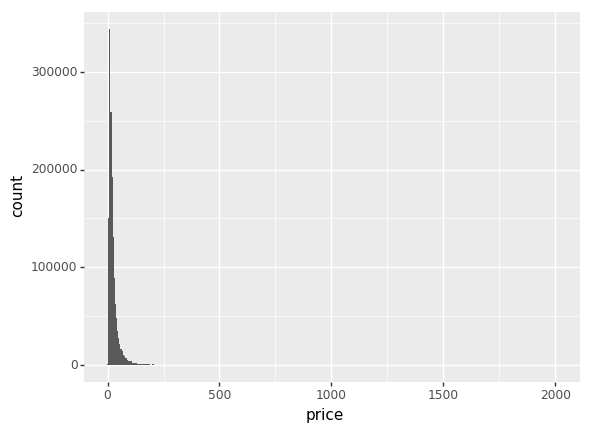

<ggplot: (-9223371887481150983)>

In [6]:
ggplot(train, aes('price')) + geom_histogram(binwidth=5)

The distribution is likely lognormal. It seems like there are quite a few '0' price products which we should consider removing.

In [21]:
train.price.sort_values(ascending = True).head(20)

1079043    0.0
644432     0.0
461372     0.0
788994     0.0
996618     0.0
1378634    0.0
729771     0.0
921821     0.0
915093     0.0
1446187    0.0
137980     0.0
416060     0.0
1332074    0.0
937578     0.0
270703     0.0
863310     0.0
506598     0.0
642067     0.0
717661     0.0
205544     0.0
Name: price, dtype: float64

# Item condition

This is a categorical variable that has 5 levels.

1 - New (codes: BNWT, BNIP MIB, NWT, NIB, BNIB)

2 - Like New (codes: BNWOT, MWOB, NWOT, BNWOB)

3 - Good

4 - Fair

5 - Poor

Notably 5 is very rare, but the few times it's been selected were for expensive things. 4 is reasonably rare.

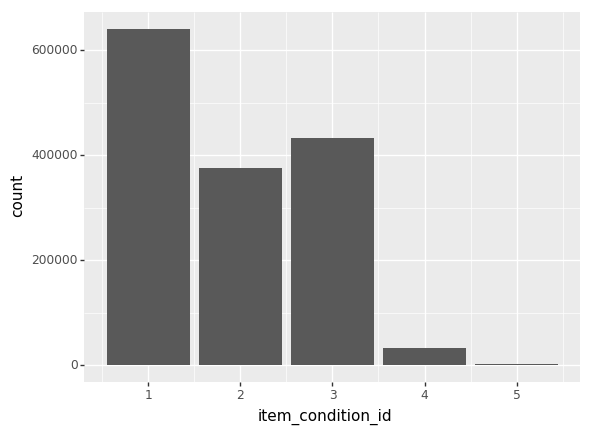

<ggplot: (-9223371898743890183)>

In [15]:
ggplot(train, aes("item_condition_id")) + geom_bar()

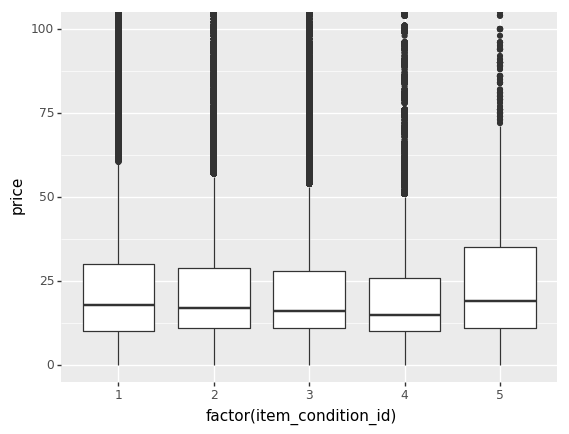

<ggplot: (-9223371898719513831)>

In [21]:
ggplot(train, aes(x="factor(item_condition_id)", y="price")) + geom_boxplot() + coord_cartesian(ylim=[0,100])

# Category Name

These category names consist of subcategory trees (Men/Tops/T-shirts). There don't appear to be more than 5 levels and the vast majority of them have just 3 levels. I am inclined to create a variable for each of the 5 levels.

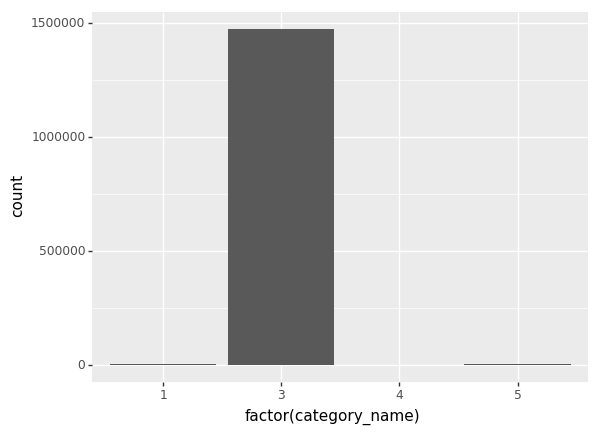

<ggplot: (138139700614)>

In [43]:
def category_depth(category_tree):
    category_tree = str(category_tree)
    return category_tree.count("/") + 1

types = train.category_name.map(category_depth)
ggplot(pd.DataFrame(types), aes("factor(category_name)")) + geom_bar()

In [44]:
types.value_counts()

3    1471819
1       6327
5       3059
4       1330
Name: category_name, dtype: int64

Here we break the category variable in to 5 seperate variables for each possible level.

In [23]:
def piece(string, delim, n):
    string = str(string)
    if string.count(delim) < n:
        return pd.np.NaN
    return string.split(delim)[n]

train["category1"] = train.category_name.map(lambda x: piece(x, "/", 0))
train["category2"] = train.category_name.map(lambda x: piece(x, "/", 1))
train["category3"] = train.category_name.map(lambda x: piece(x, "/", 2))
train["category4"] = train.category_name.map(lambda x: piece(x, "/", 3))
train["category5"] = train.category_name.map(lambda x: piece(x, "/", 4))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category1,category2,category3,category4,category5
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,NaN,NaN
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,NaN,NaN
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,NaN,NaN
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,NaN,NaN
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,NaN,NaN
